
# Introduction to Steady-state Visual Evoked Potentials (SSVEP) Brain-Computer Interfaces (BCI)



### Student Team Information

* Student 1 (20xxxxxx)
* Student 2 (20xxxxxx)
* Student 3 (20xxxxxx)

#### In this tutorial, we will be analysing a 12-class EEG SSVEP dataset. In this notebook we will explore the following aspects of EEG:
- Loading the EEG Dataset
- Plotting the raw EEG signals from this dataset
- Applying temporal filtering on the EEG signals
- Plotting the frequency domain representation of the signal (Fast Fourier Transform (FFT))
- Plotting the average frequency responses of the SSVEP signals
- Identifying the dominant frequency in the signals to classify the response into one of the 12 classes of SSVEP

### Dataset Description
In this example, there are 12 SSVEP stimuli flashing at the corresponsing flicker frequencies. The user gazes at one of the flickering targets in random order for 4 seconds. In this way 15 trials are recorded from 8 EEG channels. 

- Each .mat file has a four-way tensor electroencephalogram (EEG) data for each subject. [Number of targets, Number of channels, Number of sampling points, Number of trials]
- Number of targets : 12
- Number of channels : 8
- Number of sampling points : 1114
- Number of trials : 15
- Sampling rate [Hz] : 256

Note: The onset of visual stimulation is at 39th sample point, which means there are redundant data for 0.15 [s] before stimulus onset.

The order of the stimulus frequencies in the EEG data:
[9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75] Hz. 
(e.g., eeg(1,:,:,:) and eeg(5,:,:,:) are the EEG data while a subject was gazing at the visual stimuli flickering at 9.25 Hz and 11.75Hz, respectively.)

##### Channel Mapping:
1 - PO7, 2 - PO3, 3 - POZ, 4 - PO4, 5 - PO8, 6 - O1, 7 - OZ, 8 - O2

For more details please refer to the paper.
##### Dataset URL
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

##### Dataset Paper
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, 
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," 
PLoS One, vol.10, no.10, e140703, 2015. 
<img src="../images/12_classSSVEP.png">





In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
import numpy as np
import scipy.io as sio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scripts import ssvep_utils as su

In [3]:
FFT_PARAMS = {
    'resolution': 0.1,
    'start_frequency': 5,
    'end_frequency': 35.0,
    'sampling_rate': 256
}
data_path = os.path.abspath('../data')
window_len = 4
shift_len = 4
sample_rate = FFT_PARAMS['sampling_rate']
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75])

### Loading the Data Set
Example: Good dataset subject 7, Poor dataset subject 2.

In this section, we pick one subject's dataset and visualize the dimensions of the array/tensor.

In [4]:
subject = 8
dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
eeg = np.array(dataset['eeg'], dtype='float32')

num_classes = eeg.shape[0]
n_ch = eeg.shape[1]
total_trial_len = eeg.shape[2]
num_trials = eeg.shape[3]
total_trial_s = total_trial_len/sample_rate

In [5]:
print(f'The shape of the eeg is: {eeg.shape}')
print(f'The number of classes is: {num_classes}')
print(f'The number of channels is: {n_ch}')
print(f'The number of trials per class is: {num_trials}')
print(f'The total trial length (samples) is: {total_trial_len}')
print(f'The total trial length (seconds) is: {total_trial_s}')

The shape of the eeg is: (12, 8, 1114, 15)
The number of classes is: 12
The number of channels is: 8
The number of trials per class is: 15
The total trial length (samples) is: 1114
The total trial length (seconds) is: 4.3515625


### Plotting the raw signals and applying filtering

In [6]:
channel = 'OZ'
stim_freq = 9.75
stim_index = np.where(flicker_freq == stim_freq)[0][0]

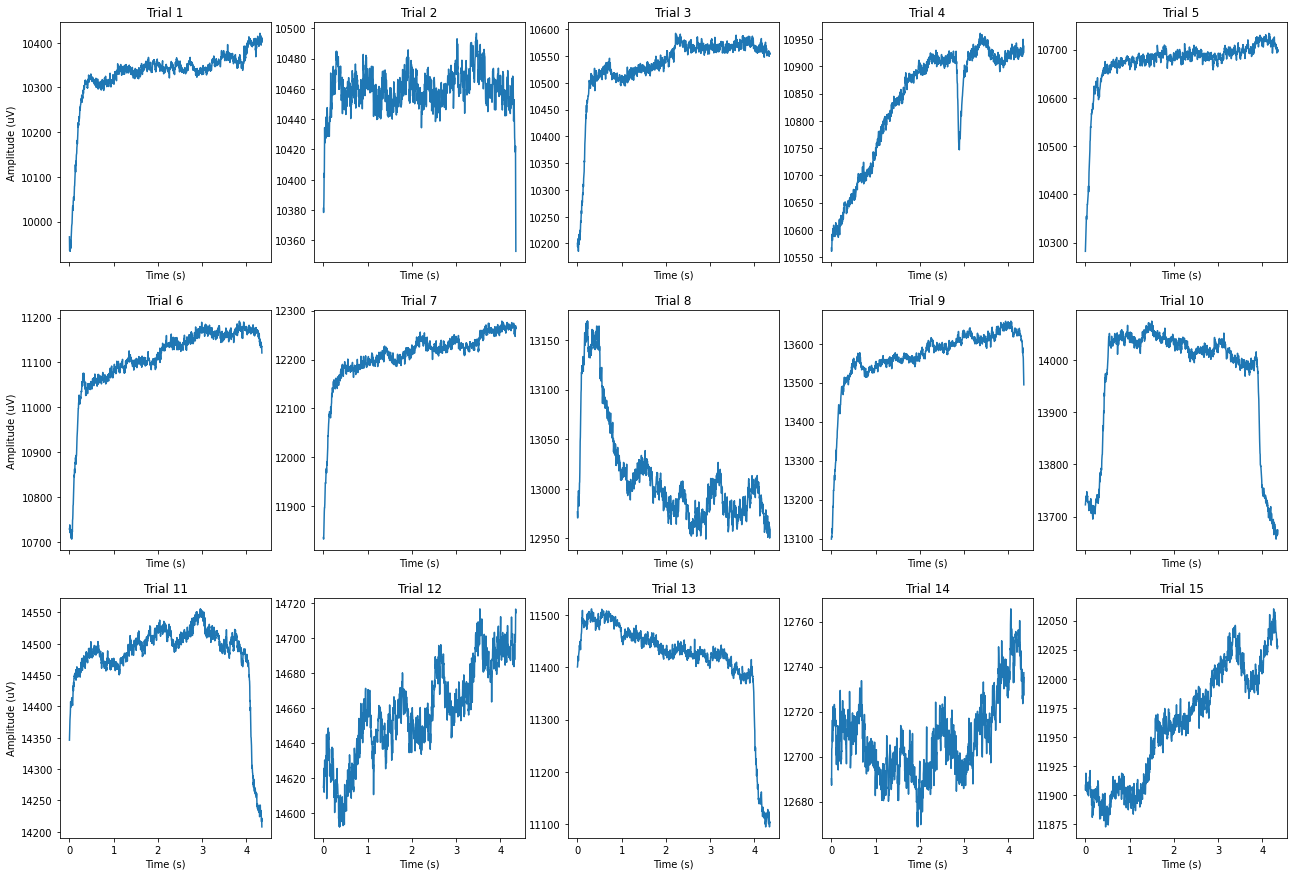

In [7]:
su.plot_time_series(eeg, stim_index, channel, sample_rate)

### Time domain signal filtered in the band 5 Hz and 35 Hz

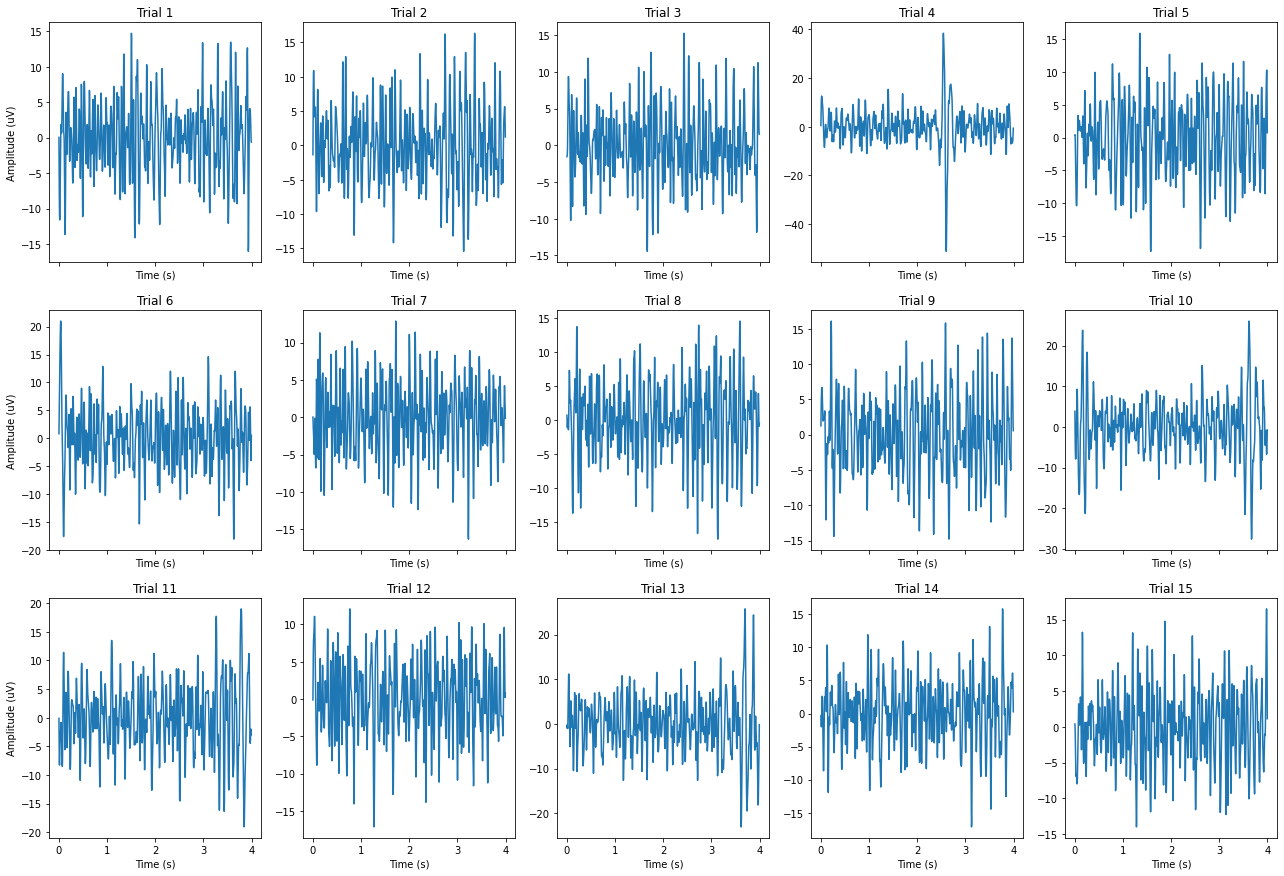

In [8]:
filtered_data = su.get_filtered_eeg(eeg, FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], 4, sample_rate)
su.plot_time_series(filtered_data, stim_index, channel, sample_rate)

### Frequency Domain Representation of the filtered signal

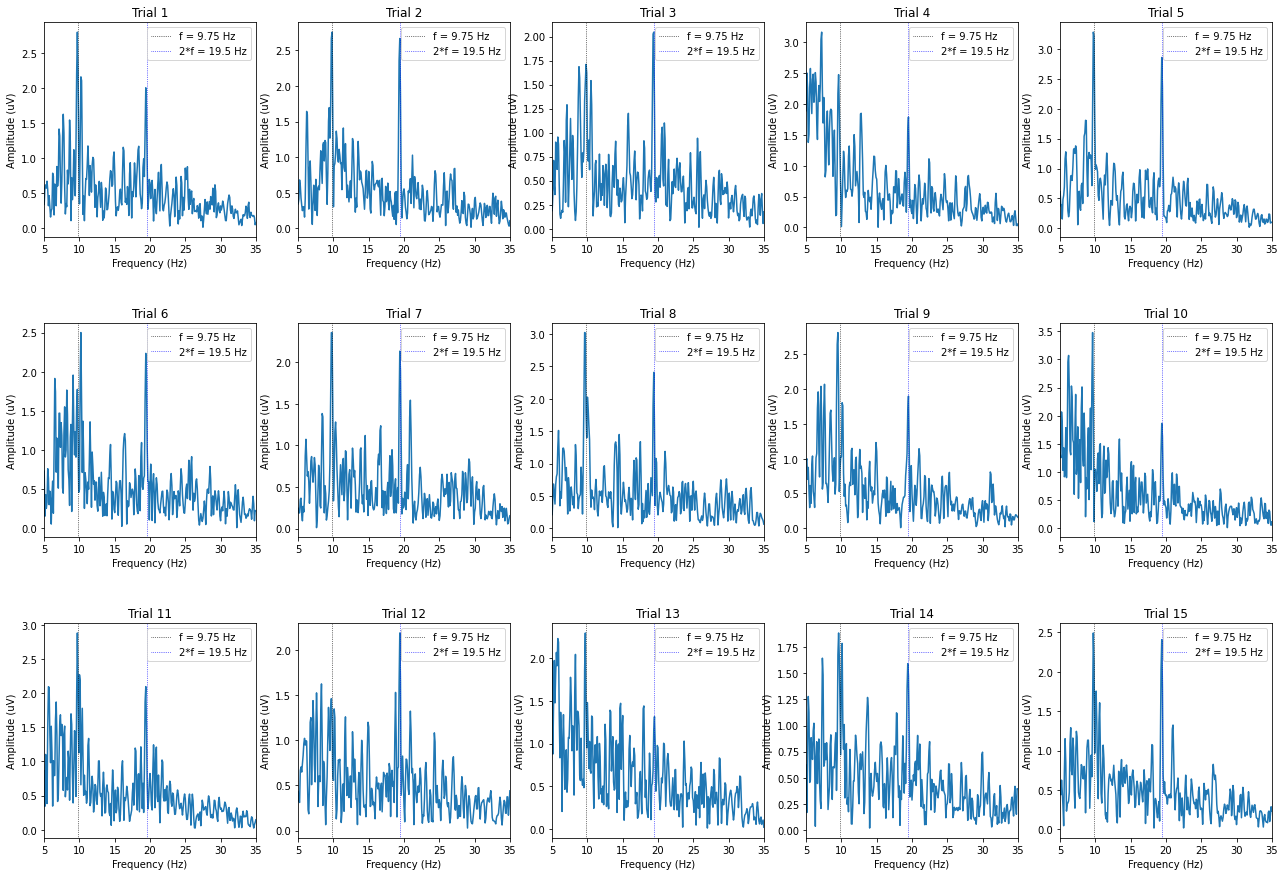

In [9]:
NFFT = round(FFT_PARAMS['sampling_rate']/FFT_PARAMS['resolution'])
fft_index_start = int(round(FFT_PARAMS['start_frequency']/FFT_PARAMS['resolution']))
fft_index_end = int(round(FFT_PARAMS['end_frequency']/FFT_PARAMS['resolution']))+1

fig, ax = plt.subplots(3, 5, figsize=(22, 15), gridspec_kw={'hspace': 0.4})
ax = ax.reshape(-1)
time_axis = np.linspace(0, total_trial_s, total_trial_len)
for trial_index in range(num_trials):
    filtered_trial = filtered_data[stim_index, su.CHANNEL_MAPPING[channel], :, trial_index]
    fft_len = filtered_trial.shape[0]
    complex_fft = np.fft.fft(filtered_trial, NFFT)/fft_len
    magnitude_spectrum = 2*np.abs(complex_fft)[fft_index_start:fft_index_end]
    fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum.shape[0])
    ax[trial_index].plot(fft_axis, magnitude_spectrum)
    ax[trial_index].axvline(stim_freq, linestyle=':', linewidth=0.7, c='k', label=f'f = {stim_freq} Hz')
    ax[trial_index].axvline(2*stim_freq, linestyle=':', linewidth=0.7, c='b', label=f'2*f = {2*stim_freq} Hz')
    ax[trial_index].set_title(f'Trial {trial_index+1}')
    ax[trial_index].set_ylabel('Amplitude (uV)')
    ax[trial_index].set_xlabel('Frequency (Hz)')
    ax[trial_index].set_xlim(fft_axis[0], fft_axis[-1])
    ax[trial_index].legend()

### Calculating the average FFT across all trials

In [10]:
magnitude_spectrum_for_all_subjects = dict()
for subject in [2, 5, 8]:
    dataset = sio.loadmat(f'{data_path}/s{subject}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    filtered_data = su.get_filtered_eeg(eeg, FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], 4, sample_rate)
    segmented_data = su.get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)
    magnitude_spectrum_for_all_subjects[f's{subject}'] = su.magnitude_spectrum_features(segmented_data, FFT_PARAMS)

In [11]:
subject_8_data = magnitude_spectrum_for_all_subjects['s8']
print(f'Subject IDs computed for: {magnitude_spectrum_for_all_subjects.keys()}')
print(f'Shape of the array computed for one subject: {subject_8_data.shape}')
print(f'Frequency dimension: {subject_8_data.shape[0]}')
print(f'Number of channels: {subject_8_data.shape[1]}')
print(f'Number of classes: {subject_8_data.shape[2]}')
print(f'Number of trials: {subject_8_data.shape[3]}')

Subject IDs computed for: dict_keys(['s2', 's5', 's8'])
Shape of the array computed for one subject: (301, 8, 12, 15, 1)
Frequency dimension: 301
Number of channels: 8
Number of classes: 12
Number of trials: 15


### Plotting the average frequency response across trials for channel Oz

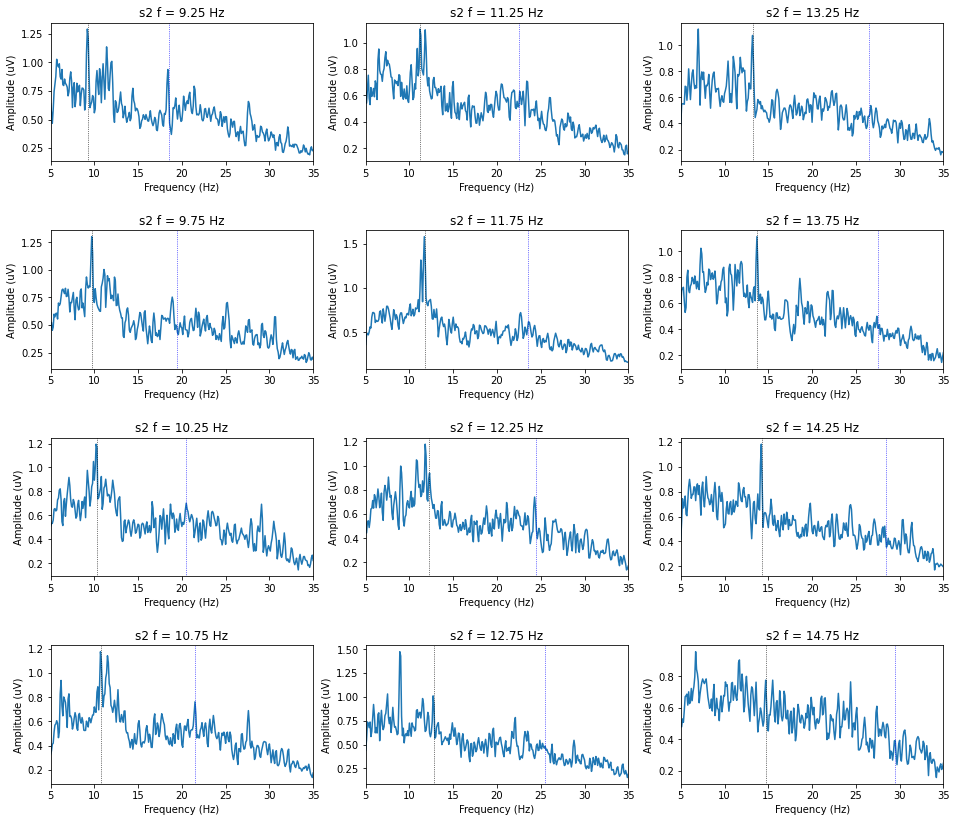

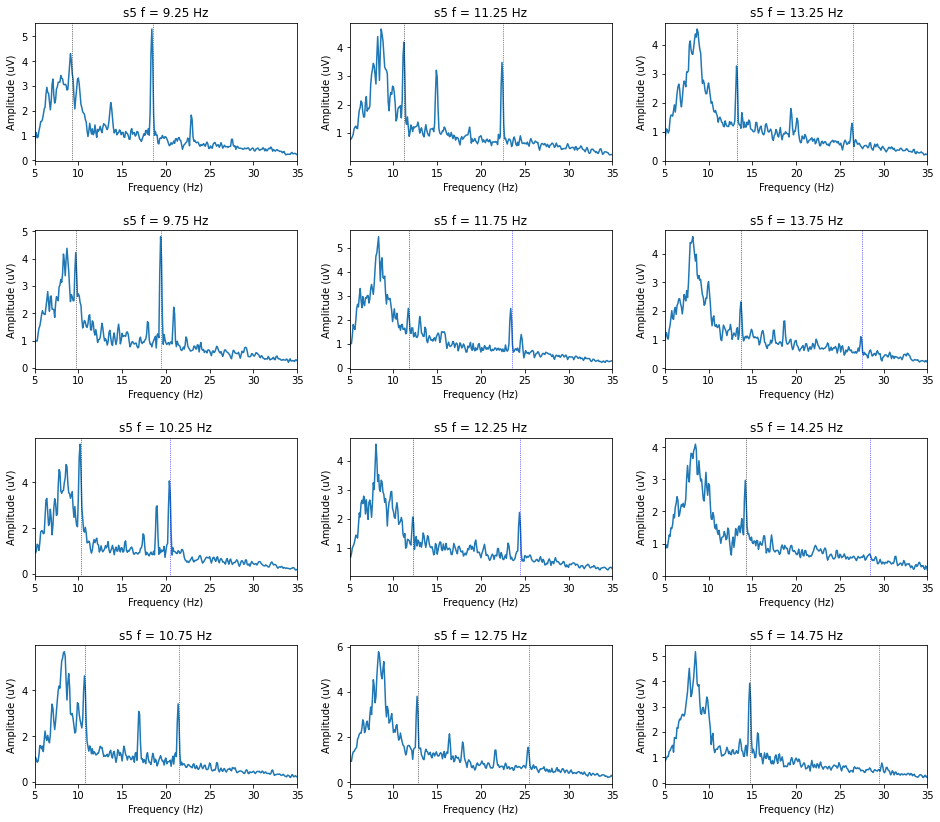

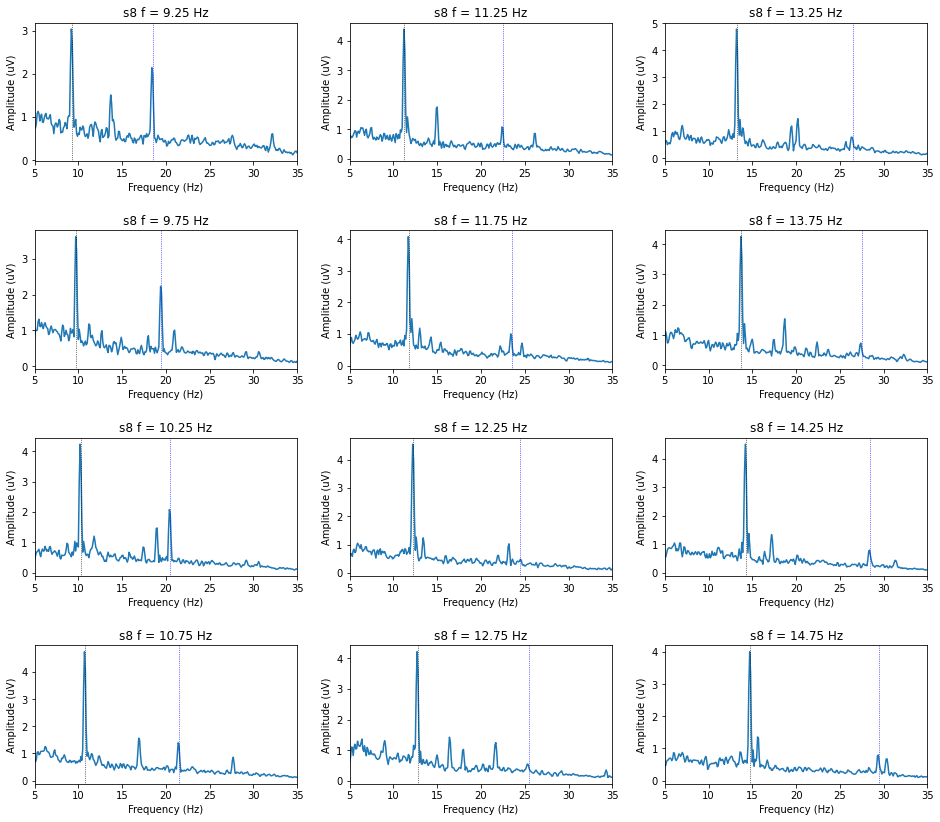

In [12]:
for subject_id, magnitude_spectrum in magnitude_spectrum_for_all_subjects.items():
    su.plot_spectrum(magnitude_spectrum, num_classes, subject_id, su.CHANNEL_MAPPING['OZ'], flicker_freq)

#### Observations
S5 has very high power in the alpha band

### Pick the dominant peak and assign the class label for this dataset from the FFT based on a single channel Oz

### Hints: 
1. Pick the maximum peak from each trial and compare it with all known frequencies (Trivial approach).
2. Pick the values at all known frequencies and pick the maximum among them (Slightly better approach).

#### Observations
Please note any observations from the results you generated

In [13]:
ground_truth_labels_dict = dict()
predicted_labels_dict = dict()
channel_idx = su.CHANNEL_MAPPING['OZ']

fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum_for_all_subjects['s2'].shape[0])
frequency_indexes_to_check = []
for val in flicker_freq:
    frequency_indexes_to_check.append(np.argmin(np.abs(fft_axis - val)))
    
for subject_id, magnitude_spectrum in magnitude_spectrum_for_all_subjects.items():
    predicted_labels_dict[subject_id] = []
    ground_truth_labels_dict[subject_id] = []
    single_channel_data = np.squeeze(magnitude_spectrum[:, channel_idx, :, :])
    fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum.shape[0])
    print(f'Single channel data dimensions: {single_channel_data.shape} for subj_id: {subject_id}')
    for class_idx in range(single_channel_data.shape[1]):
        for trial_idx in range(single_channel_data.shape[2]):
            #find the dominant frequency with the help of the fft_axis variable
            #the predicted class label is a value between 0 and 11 corresponding to the order in the flicker_freq array
            
            max_index = np.argmax(single_channel_data[frequency_indexes_to_check, class_idx, trial_idx])
            dominant_freq = fft_axis[frequency_indexes_to_check[max_index]]
            predicted_class = np.argmin(np.abs(dominant_freq - flicker_freq))
            
            predicted_labels_dict[subject_id].append(predicted_class)
            ground_truth_labels_dict[subject_id].append(class_idx)

Single channel data dimensions: (301, 12, 15) for subj_id: s2
Single channel data dimensions: (301, 12, 15) for subj_id: s5
Single channel data dimensions: (301, 12, 15) for subj_id: s8


### Performance Evaluation

Subject ID: s2 - Accuracy: 32.77777777777778 %


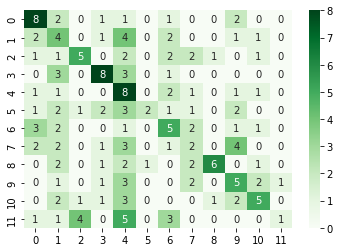

Subject ID: s5 - Accuracy: 42.22222222222222 %


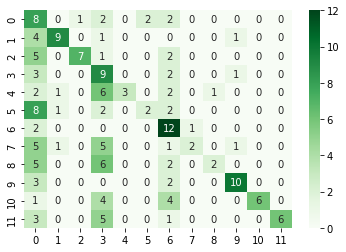

Subject ID: s8 - Accuracy: 99.44444444444444 %


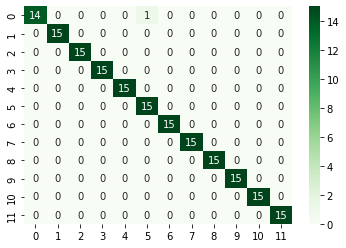

In [14]:
accuracy_dict = dict()
for subject_id in ground_truth_labels_dict.keys():
    accuracy_dict[subject_id] = su.plot_performance(ground_truth_labels_dict, predicted_labels_dict, subject_id)
    plt.show()

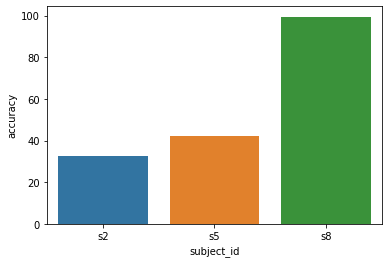

In [15]:
accuracy_df = pd.DataFrame({'subject_id': list(accuracy_dict.keys()), 'accuracy': list(accuracy_dict.values())})
sns.barplot(data=accuracy_df, x='subject_id', y='accuracy');

### Discussion

### How would you improve the performance of this classifier?
- Picking the dominant peak is a very simplistic approach
- Increase resolution of the FFT
- Use more channels
- Extract more robust features, not just dominant peak, but also the first harmonic
- Use a better classification technique

### What are some disadvantages of the current system?
- Too slow - we are using 4 seconds of data to predict the class label - slow system
